In [1]:
#from https://www.pythonforfinance.net/2019/06/26/ichimoku-trading-strategy-with-python/
import pandas as pd
import numpy as np
from pandas_datareader import data, wb
import datetime
import matplotlib.pyplot as plt
%matplotlib notebook

start = datetime.datetime(2015, 1, 1)
end = datetime.datetime(2019, 1, 27)
d=data.DataReader("AAPL", 'yahoo', start, end)[['Open','High','Low','Close']]
# Tenkan-sen (Conversion Line): (9-period high + 9-period low)/2))
nine_period_high = d['High'].rolling(window= 9).max()
nine_period_low = d['Low'].rolling(window= 9).min()
d['tenkan_sen'] = (nine_period_high + nine_period_low) /2
# Kijun-sen (Base Line): (26-period high + 26-period low)/2))
period26_high = d['High'].rolling(window=26).max()
period26_low = d['Low'].rolling(window=26).min()
d['kijun_sen'] = (period26_high + period26_low) / 2
# Senkou Span A (Leading Span A): (Conversion Line + Base Line)/2))
d['senkou_span_a'] = ((d['tenkan_sen'] + d['kijun_sen']) / 2).shift(26)
# Senkou Span B (Leading Span B): (52-period high + 52-period low)/2))
period52_high = d['High'].rolling(window=52).max()
period52_low = d['Low'].rolling(window=52).min()
d['senkou_span_b'] = ((period52_high + period52_low) / 2).shift(52)
# The most current closing price plotted 26 time periods behind (optional)
d['chikou_span'] = d['Close'].shift(-26)


C:\Users\s2007\anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
d.dropna(inplace=True)
d['above_cloud'] = 0
d['above_cloud'] = np.where((d['Low'] > d['senkou_span_a'])  & (d['Low'] > d['senkou_span_b'] ), 1, d['above_cloud'])
d['above_cloud'] = np.where((d['High'] < d['senkou_span_a']) & (d['High'] < d['senkou_span_b']), -1, d['above_cloud'])
d['A_above_B'] = np.where((d['senkou_span_a'] > d['senkou_span_b']), 1, -1)

d['tenkan_kiju_cross'] = np.NaN
d['tenkan_kiju_cross'] = np.where((d['tenkan_sen'].shift(1) <= d['kijun_sen'].shift(1)) & (d['tenkan_sen'] > d['kijun_sen']), 1, d['tenkan_kiju_cross'])
d['tenkan_kiju_cross'] = np.where((d['tenkan_sen'].shift(1) >= d['kijun_sen'].shift(1)) & (d['tenkan_sen'] < d['kijun_sen']), -1, d['tenkan_kiju_cross'])
d['price_tenkan_cross'] = np.NaN
d['price_tenkan_cross'] = np.where((d['Open'].shift(1) <= d['tenkan_sen'].shift(1)) & (d['Open'] > d['tenkan_sen']), 1, d['price_tenkan_cross'])
d['price_tenkan_cross'] = np.where((d['Open'].shift(1) >= d['tenkan_sen'].shift(1)) & (d['Open'] < d['tenkan_sen']), -1, d['price_tenkan_cross'])

d['buy'] = np.NaN
d['buy'] = np.where((d['above_cloud'].shift(1) == 1) & (d['A_above_B'].shift(1) == 1) & ((d['tenkan_kiju_cross'].shift(1) == 1) | (d['price_tenkan_cross'].shift(1) == 1)), 1, d['buy'])
d['buy'] = np.where(d['tenkan_kiju_cross'].shift(1) == -1, 0, d['buy'])
d['buy'].ffill(inplace=True)
d['sell'] = np.NaN
d['sell'] = np.where((d['above_cloud'].shift(1) == -1) & (d['A_above_B'].shift(1) == -1) & ((d['tenkan_kiju_cross'].shift(1) == -1) | (d['price_tenkan_cross'].shift(1) == -1)), -1, d['sell'])
d['sell'] = np.where(d['tenkan_kiju_cross'].shift(1) == 1, 0, d['sell'])
d['sell'].ffill(inplace=True)
d['position'] = d['buy'] + d['sell']

<IPython.core.display.Javascript object>


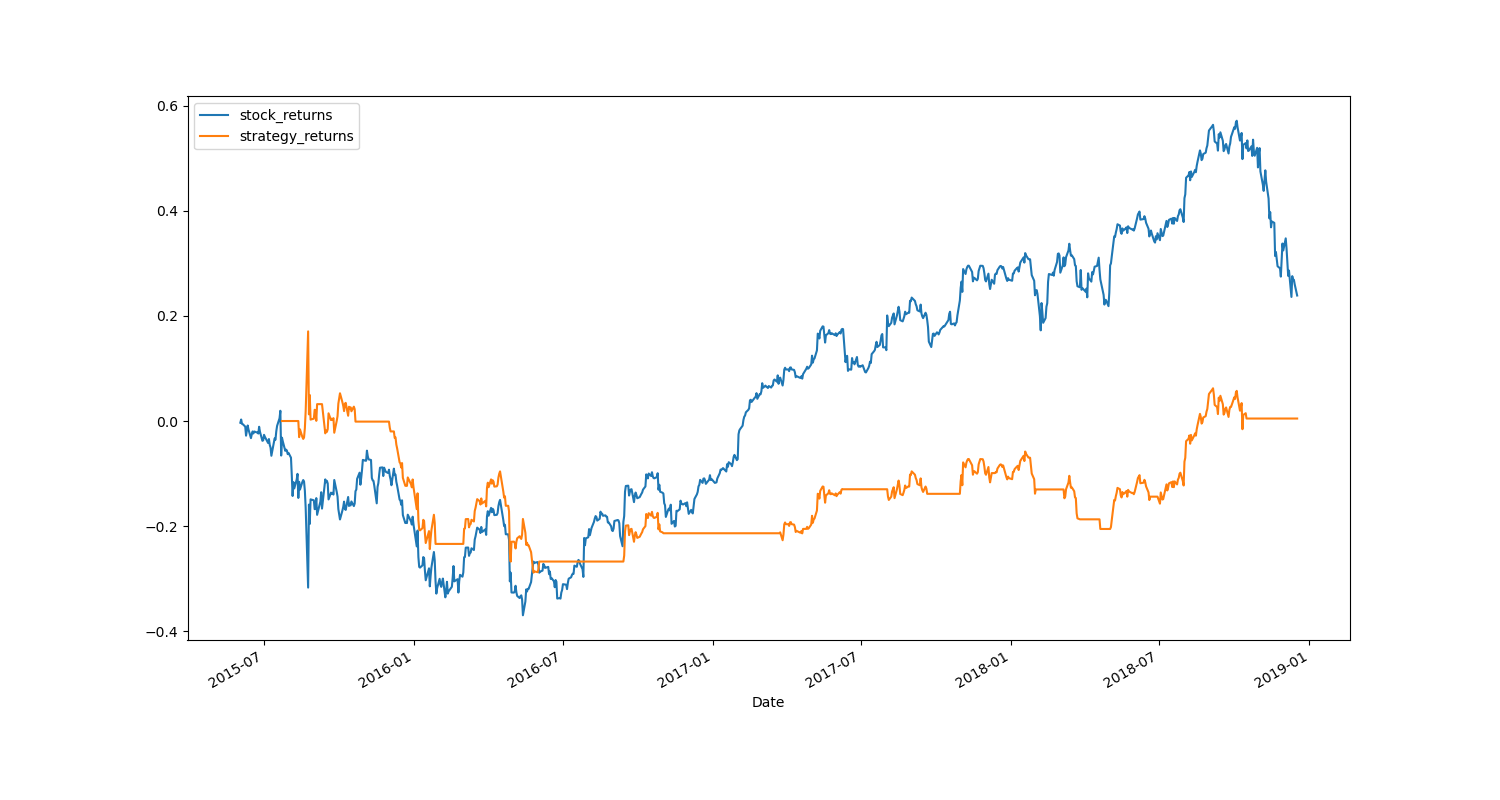

In [3]:
d['stock_returns'] = np.log(d['Open']) - np.log(d['Open'].shift(1))
d['strategy_returns'] = d['stock_returns'] * d['position']
d[['stock_returns','strategy_returns']].cumsum().plot(figsize=(15,8))